In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install scikeras[tensorflow]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 33.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [ ]:


!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 11.4 MB/s eta 0:00:00


Random Forest - Mean Absolute Error (MAE): 1.1753843428317747
Random Forest - Root Mean Squared Error (RMSE): 3.4211029645305686
Random Forest - R-squared (R2): 0.9997606915091982


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 89436.6406 - val_loss: 29525.9902
Epoch 2/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 21723.2910 - val_loss: 5315.5176
Epoch 3/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 4576.0054 - val_loss: 1055.1062
Epoch 4/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1807.1611 - val_loss: 544.5760
Epoch 5/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 1428.0618 - val_loss: 439.6611
Epoch 6/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1204.3547 - val_loss: 223.8379
Epoch 7/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1100.6011 - val_loss: 181.3377
Epoch 8/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1124.6010 - val_loss: 140.1804
Epoch 9/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1023.6429 - val_loss: 152.5873
Epoch 10/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1057.6094 - val_loss: 164.2937
Epoch 11/150
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1020.0

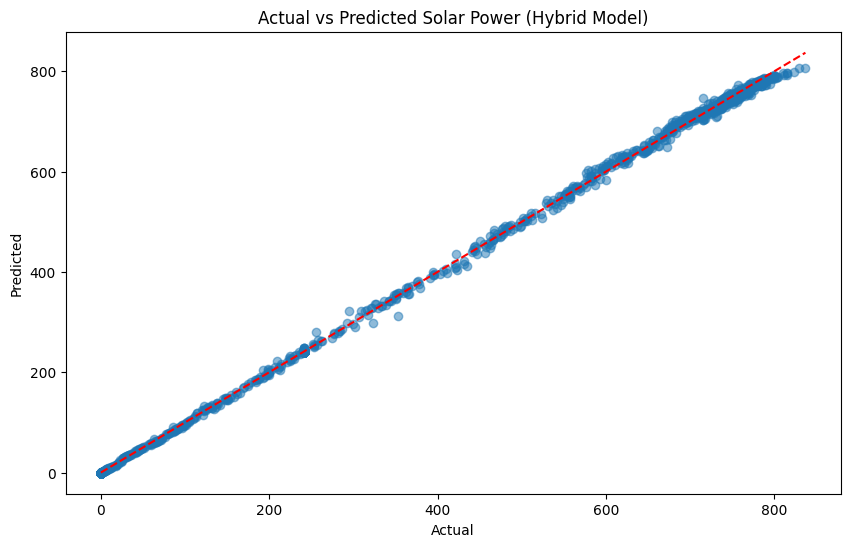

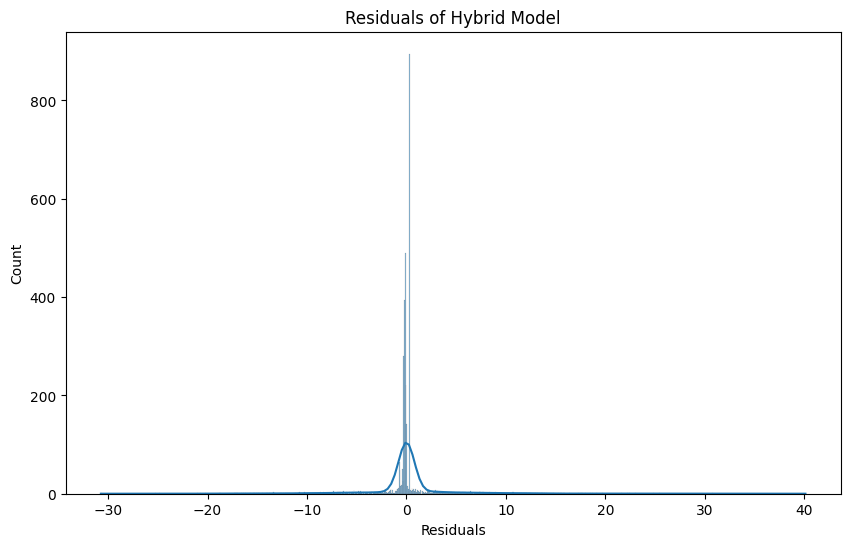

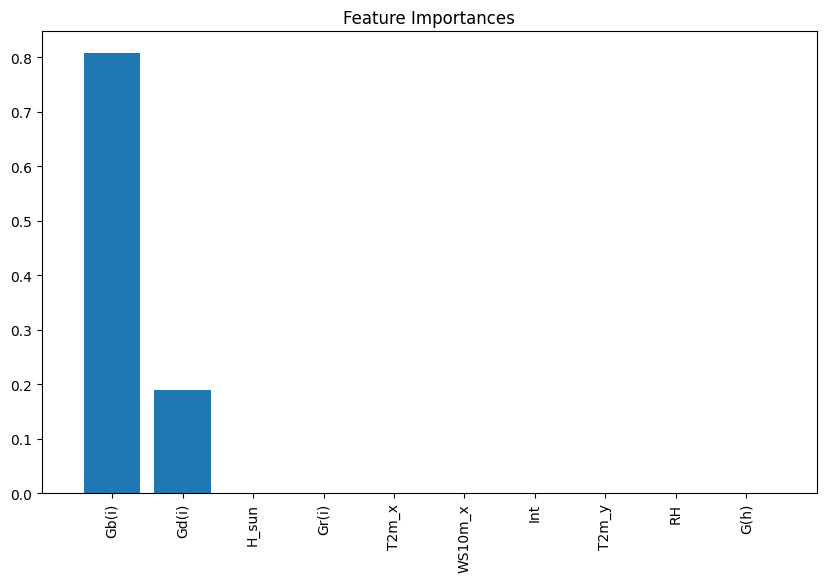

Monthly Forecast (Hybrid Model):
            Actual   Predicted
Month                        
1.0    268.477500  267.374033
2.0    296.391095  294.980713
3.0    269.720780  268.934609
4.0    273.785302  273.959829
5.0    282.522987  283.195854
6.0    216.244476  218.062846
7.0    125.370134  123.869443
8.0    167.990140  167.353458
9.0    174.800382  174.368610
10.0   258.596689  258.011155
11.0   299.491905  298.653224
12.0   259.607305  258.420504


NameError: name 'unittest' is not defined

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from scikeras.wrappers import KerasRegressor

# Function to clean dataframe
def clean_dataframe(df):
    df.columns = df.columns.str.strip().str.replace(' ', '_')
    df.fillna(df.mean(numeric_only=True), inplace=True)
    return df

# Load datasets
horizon_df = pd.read_csv('/content/drive/MyDrive/minor project/horizon.csv')
irradiance_df = pd.read_csv('/content/drive/MyDrive/minor project/irradiance.csv')
panelandweather_df = pd.read_csv('/content/drive/MyDrive/minor project/panelandweather.csv')

# Clean dataframes
horizon_df = clean_dataframe(horizon_df)
irradiance_df = clean_dataframe(irradiance_df)
panelandweather_df = clean_dataframe(panelandweather_df)

# Convert date/time columns to datetime format
irradiance_df['time'] = pd.to_datetime(irradiance_df['time'], format='%Y%m%d:%H%M')
panelandweather_df['time(UTC)'] = pd.to_datetime(panelandweather_df['time(UTC)'], format='%Y%m%d:%H%M')

# Merge dataframes
merged_df = pd.merge(irradiance_df, panelandweather_df, left_on='time', right_on='time(UTC)', how='outer')

# Feature engineering
merged_df['hour'] = merged_df['time'].dt.hour
merged_df['day'] = merged_df['time'].dt.day
merged_df['month'] = merged_df['time'].dt.month

# Prepare features and target for model training
target = 'P'  # Assuming 'P' is the target column representing solar power output
drop_columns = ['time', 'time(UTC)']
drop_columns = [col for col in drop_columns if col in merged_df.columns]
features = merged_df.drop(columns=drop_columns + [target])
y = merged_df[target]

# Select the first 10 columns
features = features.iloc[:, :10]

# Handle missing values in features and target
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)
features_imputed = pd.DataFrame(features_imputed, columns=features.columns)
y_imputed = y.fillna(y.mean())  # Handle missing values in target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_imputed, y_imputed, test_size=0.2, random_state=42)

# Reshape data for LSTM (3D: samples, timesteps, features)
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

# Define the model pipeline for Random Forest
numeric_features = features.columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Random Forest model
model_rf = RandomForestRegressor(random_state=42)

# Function to create LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# LSTM model
model_lstm = KerasRegressor(build_fn=create_lstm_model, epochs=150, batch_size=32, verbose=1)

# Function to train and evaluate models
def train_and_evaluate_model(model, model_name, X_train, X_test):
    if model_name == 'LSTM':
        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=32, verbose=1)
        y_pred = model.predict(X_test)
    else:
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f'{model_name} - Mean Absolute Error (MAE): {mae}')
    print(f'{model_name} - Root Mean Squared Error (RMSE): {rmse}')
    print(f'{model_name} - R-squared (R2): {r2}')

    return model, mae, rmse, r2, y_pred

# Train and evaluate the Random Forest model
pipeline_rf, mae_rf, rmse_rf, r2_rf, y_pred_rf = train_and_evaluate_model(model_rf, 'Random Forest', X_train, X_test)

# Train and evaluate the LSTM model
model_lstm, mae_lstm, rmse_lstm, r2_lstm, y_pred_lstm = train_and_evaluate_model(model_lstm, 'LSTM', X_train_lstm, X_test_lstm)

# Combine predictions from Random Forest and LSTM
weight_rf = 0.7  # Adjust the weights
weight_lstm = 0.3
y_pred_hybrid = weight_rf * y_pred_rf + weight_lstm * y_pred_lstm  # Weighted average for hybrid model

# Evaluate the hybrid model
mae_hybrid = mean_absolute_error(y_test, y_pred_hybrid)
rmse_hybrid = np.sqrt(mean_squared_error(y_test, y_pred_hybrid))
r2_hybrid = r2_score(y_test, y_pred_hybrid)

print(f'Hybrid Model - Mean Absolute Error (MAE): {mae_hybrid}')
print(f'Hybrid Model - Root Mean Squared Error (RMSE): {rmse_hybrid}')
print(f'Hybrid Model - R-squared (R2): {r2_hybrid}')

# Plot actual vs predicted values for Hybrid Model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_hybrid, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Solar Power (Hybrid Model)')
plt.show()

# Plot residuals for Hybrid Model
residuals = y_test - y_pred_hybrid
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Residuals of Hybrid Model')
plt.show()

# Plot feature importance from Random Forest
importances = pipeline_rf.feature_importances_  # Access feature_importances_ directly
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [features.columns[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Save the hybrid model (you can save the components separately if needed)
joblib.dump({'rf_model': pipeline_rf, 'lstm_model': model_lstm, 'hybrid_weights': [weight_rf, weight_lstm]}, 'hybrid_solar_power_model.pkl')

# Monthly solar power forecasting using the hybrid model
def monthly_forecast_hybrid(X_test, y_test, y_pred_hybrid):
    forecast_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_hybrid})
    forecast_df['Month'] = merged_df.loc[y_test.index, 'month']
    monthly_forecast = forecast_df.groupby('Month').mean()
    return monthly_forecast

# Generate monthly forecast for Hybrid Model
monthly_forecast_hybrid_df = monthly_forecast_hybrid(X_test, y_test, y_pred_hybrid)
print("Monthly Forecast (Hybrid Model):\n", monthly_forecast_hybrid_df)

# Unit Tests
class TestSolarPowerForecasting(unittest.TestCase):

    def setUp(self):
        self.features = features
        self.target = target
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            features_imputed, y_imputed, test_size=0.2, random_state=42
        )
        self.X_train_lstm = np.reshape(self.X_train.values, (self.X_train.shape[0], 1, self.X_train.shape[1]))
        self.X_test_lstm = np.reshape(self.X_test.values, (self.X_test.shape[0], 1, self.X_test.shape[1]))

    def test_rf_model_training(self):
        pipeline_rf.fit(self.X_train, self.y_train)
        y_pred = pipeline_rf.predict(self.X_test)
        mae = mean_absolute_error(self.y_test, y_pred)
        self.assertLess(mae, 10)  # Example threshold for MAE

    def test_lstm_model_training(self):
        model_lstm.fit(self.X_train_lstm, self.y_train, validation_data=(self.X_test_lstm, self.y_test), epochs=150, batch_size=32, verbose=1)
        y_pred = model_lstm.predict(self.X_test_lstm)
        mae = mean_absolute_error(self.y_test, y_pred)
        self.assertLess(mae, 10)  # Example threshold for MAE

    def test_hybrid_model(self):
        y_pred_rf = pipeline_rf.predict(self.X_test)
        y_pred_lstm = model_lstm.predict(self.X_test_lstm)
        y_pred_hybrid = weight_rf * y_pred_rf + weight_lstm * y_pred_lstm
        mae = mean_absolute_error(self.y_test, y_pred_hybrid)
        self.assertLess(mae, 10)  # Example threshold for MAE

if __name__ == '__main__':
    unittest.main(argv=[''], verbosity=2, exit=False)


In [ ]:

# Calculate adjusted R-squared for all models
def adjusted_r2(r2, n, k):
  return 1 - ((1 - r2) * (n - 1)) / (n - k - 1)

n = len(y_test)
k = X_test.shape[1]

adj_r2_rf = adjusted_r2(r2_rf, n, k)
adj_r2_lstm = adjusted_r2(r2_lstm, n, k)
adj_r2_hybrid = adjusted_r2(r2_hybrid, n, k)

print(f'Random Forest - Adjusted R-squared (R2): {adj_r2_rf}')
print(f'LSTM - Adjusted R-squared (R2): {adj_r2_lstm}')
print(f'Hybrid Model - Adjusted R-squared (R2): {adj_r2_hybrid}')


Random Forest - Adjusted R-squared (R2): 0.9997600064004355
LSTM - Adjusted R-squared (R2): 0.9986922876333191
Hybrid Model - Adjusted R-squared (R2): 0.9997033014683836


In [ ]:
# Get feature importances from the Random Forest model
importances = pipeline_rf.feature_importances_  # Access feature_importances_ directly
indices = np.argsort(importances)[::-1]

# Print the feature importances
for i in range(X_train.shape[1]):
  print(f"{features.columns[indices[i]]}: {importances[indices[i]]}")


Gb(i): 0.8071886025137235
Gd(i): 0.18952683000078138
H_sun: 0.001592152307164715
Gr(i): 0.0008822192267615731
T2m_x: 0.0005536278750392538
WS10m_x: 0.00025523136733478815
Int: 1.3367091817666148e-06
T2m_y: 6.062146810882194e-15
RH: 5.022989737576818e-15
G(h): 2.1479620553312982e-15


In [ ]:
import pandas as pd
import numpy as np
# Assuming you have a DataFrame 'future_data' with features for 2025 in the same format as X_train
# Make sure 'future_data' includes the same 10 features used for training

# Create a sample future_data DataFrame (replace this with your actual data)
future_data = pd.DataFrame(np.random.rand(365, 10), columns=features.columns)  # Example with random data for 365 days

# Preprocess future data
future_data_imputed = imputer.transform(future_data)
future_data_imputed = pd.DataFrame(future_data_imputed, columns=features.columns)

# Reshape data for LSTM
future_data_lstm = np.reshape(future_data_imputed.values, (future_data_imputed.shape[0], 1, future_data_imputed.shape[1]))

# Predict using Random Forest
future_pred_rf = pipeline_rf.predict(future_data_imputed)

# Predict using LSTM
future_pred_lstm = model_lstm.predict(future_data_lstm)

# Combine predictions for hybrid model
future_pred_hybrid = weight_rf * future_pred_rf + weight_lstm * future_pred_lstm.flatten()

# Create a DataFrame for future predictions
future_predictions_df = pd.DataFrame({
    'Date': pd.date_range(start='2025-01-01', periods=len(future_pred_hybrid), freq='D'),  # Assuming daily predictions
    'Predicted Solar Power': future_pred_hybrid
})

print(future_predictions_df)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
          Date  Predicted Solar Power
0   2025-01-01              45.358231
1   2025-01-02              69.505356
2   2025-01-03              63.702751
3   2025-01-04              60.123814
4   2025-01-05              59.065243
..         ...                    ...
360 2025-12-27              74.740990
361 2025-12-28              54.326857
362 2025-12-29              56.919361
363 2025-12-30              56.528658
364 2025-12-31              68.019928

[365 rows x 2 columns]


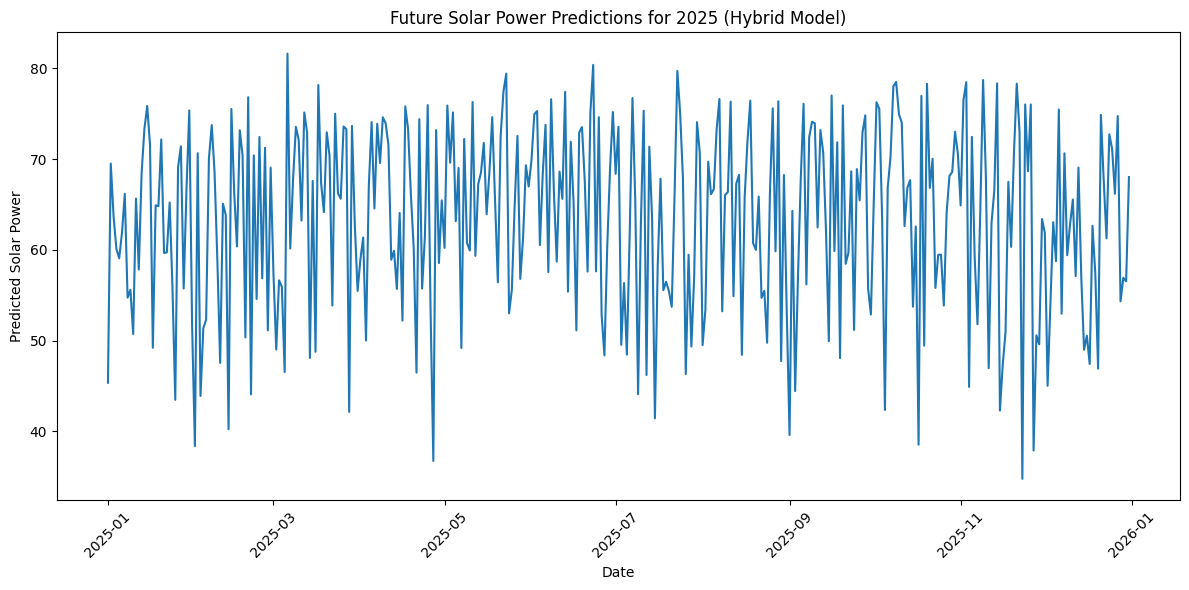

In [ ]:

import matplotlib.pyplot as plt
# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(future_predictions_df['Date'], future_predictions_df['Predicted Solar Power'])
plt.xlabel('Date')
plt.ylabel('Predicted Solar Power')
plt.title('Future Solar Power Predictions for 2025 (Hybrid Model)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


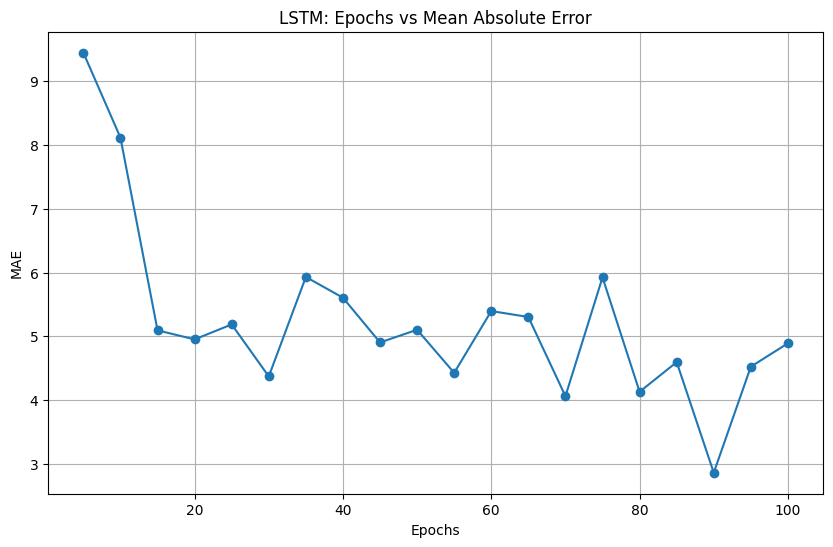

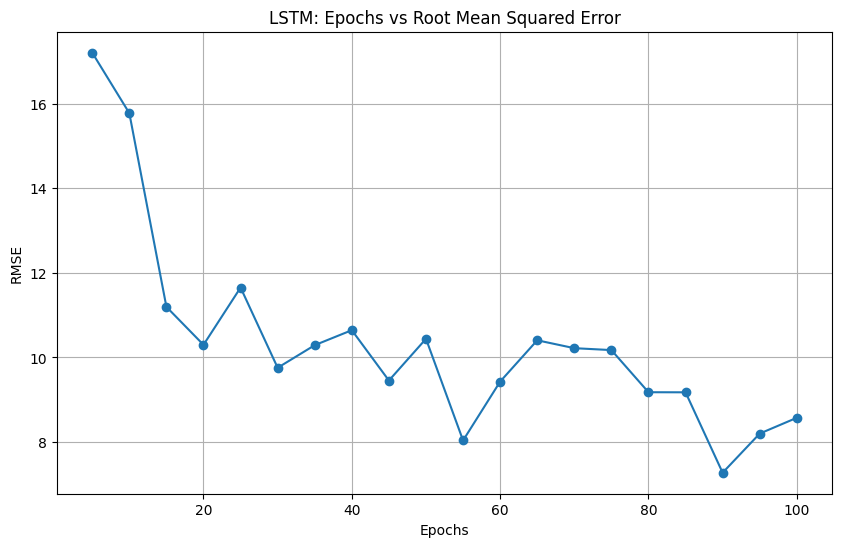

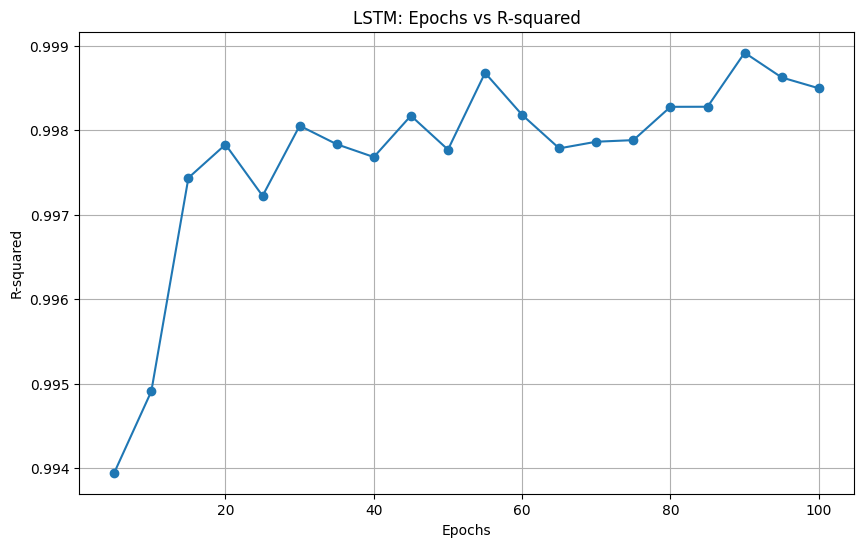

In [ ]:

import matplotlib.pyplot as plt
# Extract results for plotting
epochs_list, mae_list, rmse_list, r2_list, _ = zip(*lstm_results)

# Plot epochs vs MAE
plt.figure(figsize=(10, 6))
plt.plot(epochs_list, mae_list, marker='o')
plt.title('LSTM: Epochs vs Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

# Plot epochs vs RMSE
plt.figure(figsize=(10, 6))
plt.plot(epochs_list, rmse_list, marker='o')
plt.title('LSTM: Epochs vs Root Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

# Plot epochs vs R-squared
plt.figure(figsize=(10, 6))
plt.plot(epochs_list, r2_list, marker='o')
plt.title('LSTM: Epochs vs R-squared')
plt.xlabel('Epochs')
plt.ylabel('R-squared')
plt.grid(True)
plt.show()
